In [1]:
import pandas as pd

import torch
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from common import *

#### Load data

<Axes: ylabel='count'>

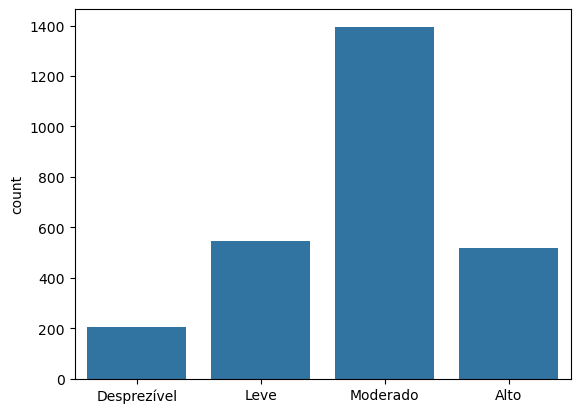

In [2]:
train_data = pd.read_csv("../../data/ld50/train.csv")
test_data = pd.read_csv("../../data/ld50/test.csv")

Y_train = train_data["Class"]
Y_test = test_data["Class"]

X_train = pd.read_csv("train_embeddings.csv")
X_test = pd.read_csv("test_embeddings.csv")

X_train.describe(), Y_train.describe()

counts = Y_test.value_counts().sort_index()
counts.index = class_labels = ["Alto", "Moderado", "Leve", "Desprezível"][::-1]

sns.barplot(counts)

#### Load model and extend layers

In [3]:
head = torch.nn.Sequential(
            torch.nn.Linear(768, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 4)
        )

#### Full model training

In [4]:
class SmilesDataset(Dataset):
    def __init__(self, x: pd.DataFrame, y: pd.Series):
        self.X = x
        self.Y = y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index: int):
        x = torch.tensor(self.X.iloc[index].values).float()
        y = torch.tensor(self.Y.iloc[index]).long()
        return x, y

train_dataset = SmilesDataset(X_train, Y_train)
test_dataset = SmilesDataset(X_test, Y_test)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
class_weights = compute_class_weight(class_weight='balanced', classes=Y_train.unique(), y=Y_train.values)

optimizer = optim.Adam(head.parameters(), lr=12e-5)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights).float())
num_epochs = 200

for epoch_index in range(num_epochs):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(train_dataloader):
        if i == 0:
            running_loss = 0.
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = head(inputs)

        # Compute the loss and its gradients
        loss = criterion(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

        if i % 20 == 19:
            last_loss = running_loss / 20 # loss per batch
            print('Epoch {}  batch {} loss: {}'.format(epoch_index, i + 1, last_loss))
            running_loss = 0.

Epoch 0  batch 20 loss: 1.1474216759204865
Epoch 0  batch 40 loss: 1.08189857006073
Epoch 0  batch 60 loss: 1.0837666511535644
Epoch 0  batch 80 loss: 1.0139651328325272
Epoch 0  batch 100 loss: 0.9748673945665359
Epoch 0  batch 120 loss: 0.9392579346895218
Epoch 0  batch 140 loss: 0.9898822605609894
Epoch 0  batch 160 loss: 0.9898628294467926
Epoch 0  batch 180 loss: 0.8930535048246384
Epoch 0  batch 200 loss: 0.9627717524766922
Epoch 0  batch 220 loss: 0.9411010056734085
Epoch 0  batch 240 loss: 0.9191264301538468
Epoch 1  batch 20 loss: 0.7418116897344589
Epoch 1  batch 40 loss: 0.7974947452545166
Epoch 1  batch 60 loss: 0.7450980901718139
Epoch 1  batch 80 loss: 0.7736074566841126
Epoch 1  batch 100 loss: 0.7817731976509095
Epoch 1  batch 120 loss: 0.8009663701057435
Epoch 1  batch 140 loss: 0.8102664560079574
Epoch 1  batch 160 loss: 0.799621257185936
Epoch 1  batch 180 loss: 0.7923837333917618
Epoch 1  batch 200 loss: 0.8122176349163055
Epoch 1  batch 220 loss: 0.8060071647167206

In [6]:
# 5min13s

from datetime import datetime
torch.save(head.state_dict(), f"nn_model_classification_{datetime.now().isoformat()}")

              precision    recall  f1-score   support

           0       0.65      0.58      0.61       206
           1       0.53      0.47      0.50       548
           2       0.69      0.75      0.72      1395
           3       0.60      0.54      0.57       517

    accuracy                           0.64      2666
   macro avg       0.61      0.58      0.60      2666
weighted avg       0.63      0.64      0.63      2666



/opt/homebrew/anaconda3/envs/molformer2/lib/python3.8/site-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


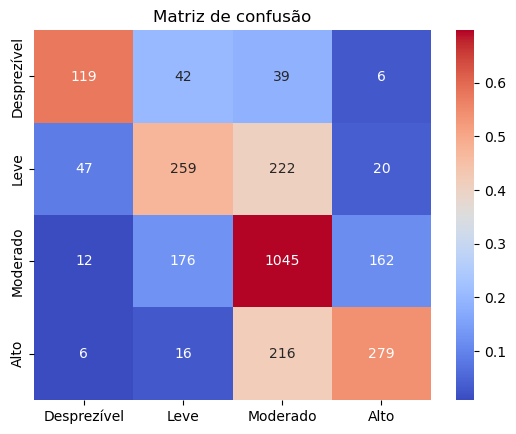

In [7]:
inputs = torch.tensor(X_test.values).float()
outputs = head(inputs)
pred = torch.nn.Softmax()(outputs)
pred = pred.argmax(axis=1)

import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
matrix = np.zeros((4, 4), dtype=np.float64)
for i, (p, t) in enumerate(zip(pred, Y_test)):
    matrix[t, p] += 1

annot = np.copy(matrix)
for i, count in enumerate(Y_test.value_counts().sort_index()):
    matrix[i] /= count

sns.heatmap(matrix, cmap='coolwarm', robust=True, annot=annot, fmt='g', xticklabels=class_labels, yticklabels=class_labels).set_title("Matriz de confusão")

from sklearn.metrics import classification_report
print(classification_report(Y_test.values, pred))